In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score,StratifiedKFold,RepeatedStratifiedKFold, cross_validate
from copy import deepcopy

from time import time
from sklearn.preprocessing import FunctionTransformer

In [2]:
df = pd.read_csv('../../../data/raw/DataTrain_Preliminary.csv',sep = ";",na_values = ['*',99999])
df_test = pd.read_csv('../../../data/raw/Data_Prediction.csv',sep = ";")
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,0.0,tcp,private,SH,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.01,0.94,0.95,0.0,0.95,1.0,0.0,0.0,nmap
1,0.0,tcp,private,S0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.02,0.08,0.00,0.0,1.00,1.0,0.0,0.0,neptune
2,0.0,tcp,http,SF,285.0,3623.0,0.0,0.0,0.0,0.0,...,228.0,1.00,0.00,0.01,NaN,0.00,0.0,0.0,0.0,normal
3,0.0,tcp,http,SF,232.0,584.0,0.0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.17,NaN,0.00,0.0,0.0,0.0,normal
4,1.0,tcp,smtp,SF,1080.0,327.0,0.0,0.0,0.0,0.0,...,154.0,0.58,0.02,0.00,NaN,0.00,0.0,0.0,0.0,normal


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112446 entries, 0 to 112445
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     111526 non-null  float64
 1   protocol_type                111778 non-null  object 
 2   service                      111426 non-null  object 
 3   flag                         111593 non-null  object 
 4   src_bytes                    111398 non-null  float64
 5   dst_bytes                    111718 non-null  float64
 6   land                         112038 non-null  float64
 7   wrong_fragment               111923 non-null  float64
 8   urgent                       112078 non-null  float64
 9   hot                          111528 non-null  float64
 10  num_failed_logins            111862 non-null  float64
 11  logged_in                    112276 non-null  float64
 12  num_compromised              111995 non-null  float64
 13 

In [4]:
## stratified shuffle
X = df.drop(columns="type_of_attack")

#label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df["type_of_attack"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((89956, 41), (22490, 41), (89956,), (22490,))

In [5]:
#make custom transformer
from sklearn.base import BaseEstimator, TransformerMixin

def value_impute(data):
    #if value is nan, then impute with 0, if value = inf, replcae with -1
    if data == np.Inf:
        data = -1
    if data == np.nan:
        data = 0
    return data

class FeatureEngineering(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X_ = X.copy()
        X_['src_bytes_per_duration'] = X_['src_bytes']/X_['duration']
        X_['src_bytes_per_duration'] = X_.src_bytes_per_duration.apply(lambda x : value_impute(x))
        
        X_['dst_bytes_per_duration'] = X_['dst_bytes']/X_['duration']
        X_['dst_bytes_per_duration'] = X_.dst_bytes_per_duration.apply(lambda x:value_impute(x))

        X_['total_bytes_per_duration'] = (X_['src_bytes'] + X_["dst_bytes"]) / X_['duration']
        X_['total_bytes_per_duration'] = X_['total_bytes_per_duration'].apply(lambda x:value_impute(x))

        X_['num_access_use'] = X_['num_root'] + X_['num_file_creations'] + X_['num_shells'] + X_['num_access_files'] + X_['num_outbound_cmds']
        X_['num_access_use'] = X_.num_access_use.apply(lambda x:value_impute(x))

        X_['total_bytes'] = X_['src_bytes'] + X_['dst_bytes']
        X_['connection_rate'] = X_['count'] / X_['duration']
        X_['connection_rate'] = X_['connection_rate'].apply(lambda x:value_impute(x))

        X_['host_error_rate'] = X_["dst_host_serror_rate"] + X_['dst_host_rerror_rate']
        X_['success_login_ratio'] = X_['num_compromised'] / (X_['num_compromised'] + X_['num_failed_logins'])
        X_['success_login_ratio'] = X_['success_login_ratio'].apply(lambda x:value_impute(x))

        X_['connection_stability'] = X_[['serror_rate','rerror_rate','srv_serror_rate','srv_rerror_rate']].std(axis = 1)
        X_['flag_rate']  = X_['count'] * (X_['serror_rate'] + X_['rerror_rate'] + X_['srv_serror_rate'] + X_['srv_rerror_rate'])

        return X_

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
#one hot encoder
from sklearn.preprocessing import OneHotEncoder,TargetEncoder

cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()
num_columns = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
feat_eng_cols = ['src_bytes_per_duration','dst_bytes_per_duration','total_bytes_per_duration','num_access_use','total_bytes','connection_rate','host_error_rate','success_login_ratio','connection_stability','flag_rate']
num_columns = num_columns + feat_eng_cols

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", PowerTransformer())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", TargetEncoder(target_type="continuous"))
])

preprocessor = ColumnTransformer([
("numerical",num_pipe,num_columns),
("categorical",cat_pipe,cat_columns)
],remainder = "drop",verbose_feature_names_out=False).set_output(transform="pandas")

In [7]:
prep_pipeline = Pipeline([
    ("feature_engineering",FeatureEngineering()),
    ("preprocessor",preprocessor)
])
prep_pipeline.fit_transform(X_train,y_train)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,num_access_use,total_bytes,connection_rate,host_error_rate,success_login_ratio,connection_stability,flag_rate,protocol_type,service,flag
28785,3.414620,1.252543,1.477024,-0.059964,-0.114987,-0.057722,-0.160748,-0.073958,-0.802468,-0.119188,...,-0.156442,1.352231,3.140214,0.381240,-0.080426,1.213671,1.074481,3.210615,4.000000,4.740713
17955,-0.303621,-1.118167,-0.907318,-0.059964,-0.114987,-0.057722,-0.160748,-0.073958,-0.802468,-0.119188,...,-0.156442,-1.114259,-0.322673,1.233217,-0.080426,1.213671,1.364106,3.201653,2.021100,3.262463
53215,-0.303621,0.738515,1.371580,-0.059964,-0.114987,-0.057722,-0.160748,-0.073958,1.247942,-0.119188,...,-0.156442,1.159786,-0.322673,-0.916557,-0.080426,-0.819938,-0.857361,3.206790,3.845286,3.898275
62918,-0.303621,0.782020,1.157689,-0.059964,-0.114987,-0.057722,-0.160748,-0.073958,1.247942,-0.119188,...,-0.156442,0.875326,-0.322673,-0.916557,-0.080426,-0.819938,-0.857361,3.210912,3.846014,3.898514
92112,-0.303621,0.279307,0.585500,-0.059964,-0.114987,-0.057722,-0.160748,-0.073958,-0.802468,-0.119188,...,-0.156442,0.256416,-0.322673,-0.916557,-0.080426,-0.819938,-0.857361,3.941451,4.002341,3.898514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107880,-0.303621,-1.118167,-0.907318,-0.059964,-0.114987,-0.057722,-0.160748,-0.073958,-0.802468,-0.119188,...,-0.156442,-1.114259,-0.322673,1.233217,-0.080426,1.213671,1.204270,3.206790,2.650413,3.266711
103417,3.414126,0.560720,0.375290,-0.059964,-0.114987,-0.057722,-0.160748,-0.073958,-0.802468,-0.119188,...,-0.156442,0.298238,3.141283,-0.916557,-0.080426,-0.819938,-0.857361,3.937464,4.002725,3.898275
106904,-0.303621,-0.203388,0.770292,-0.059964,-0.114987,-0.057722,-0.160748,-0.073958,-0.802468,-0.119188,...,-0.156442,0.358737,-0.322673,0.381240,-0.080426,-0.819938,-0.857361,3.210615,2.647708,3.893952
12004,-0.303621,0.854339,1.254430,-0.059964,-0.114987,-0.057722,-0.160748,-0.073958,1.247942,-0.119188,...,6.392141,1.002168,-0.322673,-0.916557,-0.080426,-0.819938,-0.857361,3.210615,3.842258,3.893952


In [13]:
import umap

reducer = umap.UMAP(random_state=42)
reducer.fit(prep_pipeline.fit_transform(X_train,y_train),y = y_train)

d:\conda\envs\lomba-dac\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
d:\conda\envs\lomba-dac\lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
d:\conda\envs\lomba-dac\lib\site-packages\sklearn\manifold\_spectral_embedding.py:392: UserWarning: Exited at iteration 2000 with accuracies 
[5.11433435e-15 5.36632845e-07 1.17918597e-06 3.12782606e-05]
not reaching the requested tolerance 1.7583370208740234e-06.
Use iteration 733 instead with accuracy 
6.0877905491840525e-06.

  _, diffusion_map = lobpcg(
d:\conda\envs\lomba-dac\lib\site-packages\sklearn\manifold\_spectral_embedding.py:392: UserWarning: Exited postprocessing with accuracies 
[1.35531159e-15 5.84942976e-07 1.2829855

KeyboardInterrupt: 

In [11]:
embedding = reducer.transform(prep_pipeline.fit_transform(X_train,y_train))

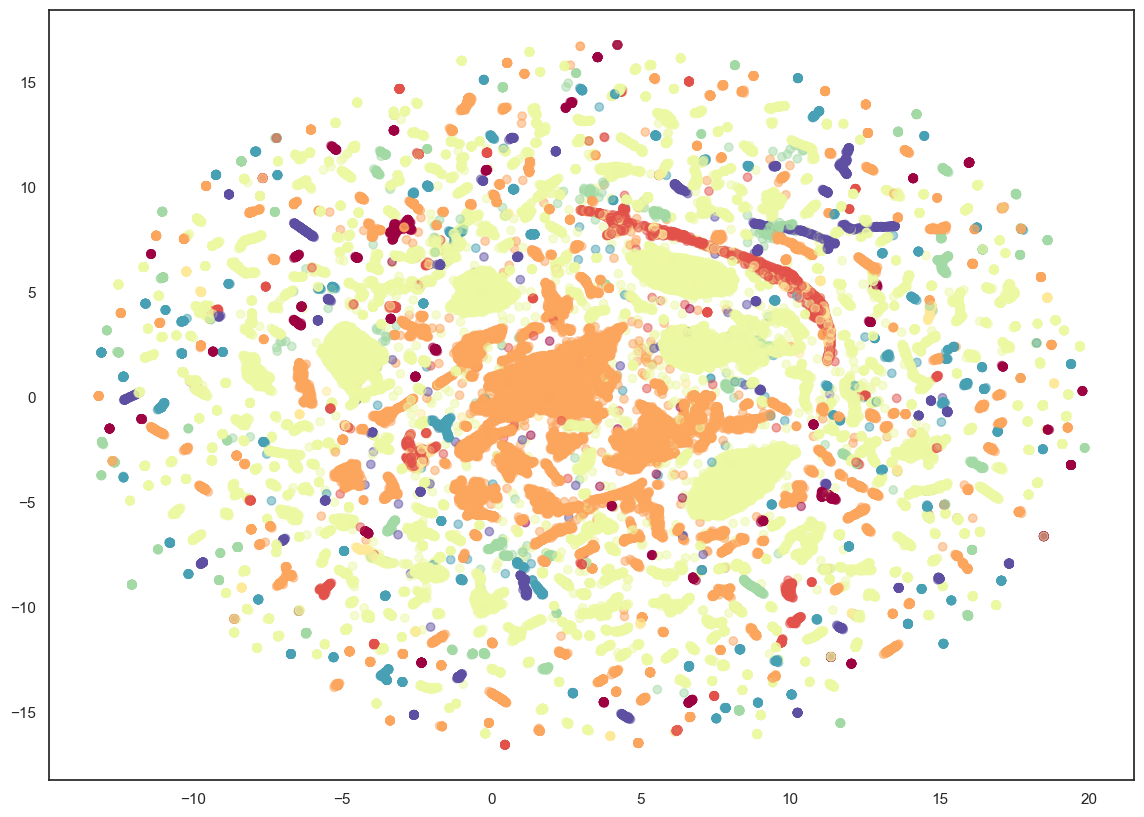

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=y_train,
    cmap='Spectral',
    alpha=0.5
)